# LAB06 Assigment




### Exercise 1 Linear Discriminant Analysis from Scratch using numpy (50 points )
- <font size=4> Complete the missing code in the LDA class below<font>

In [1]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)


/tmp/ipykernel_141246/2538124969.py:3: MatplotlibDeprecationWarning: MatplotlibDeprecationWarning was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(5)


iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
import numpy as np
import matplotlib.pyplot as plt


class LDA:
    #n_components:Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction.
    def __init__(self, n_components=None):
        
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None
        self.class_mean = None


    def fit(self, X, y):
        if self.n_components is None or self.n_components > X.shape[1]:
            n_components = X.shape[1]
        else:
            n_components = self.n_components
       
        n_features = np.shape(X)[1]
        labels = np.unique(y)
  
        # Within class scatter matrix
        # Complete code for calculating S_W

        S_W = np.zeros((n_features, n_features))
        for label in labels:
            class_data = X[y == label]
            class_scatter = np.cov(class_data, rowvar=False)
            S_W += class_scatter


        # Between class scatter matrix
        # Complete code for calculating S_B

        overall_mean = np.mean(X, axis=0)
        class_mean_matrix = np.zeros(n_features)
        S_B = np.zeros((n_features, n_features))
        for label in labels:
            class_data = X[y == label]
            class_mean = np.mean(class_data, axis=0)
        
            n = class_data.shape[0]
            mean_diff = (class_mean - overall_mean).reshape(-1, 1)
            S_B += n * np.dot(mean_diff, mean_diff.T)
            class_mean_matrix = np.vstack([class_mean_matrix, class_mean])

        self.class_mean = class_mean_matrix[1:]

        # Determine SW^-1 * SB by calculating inverse of SW
        determinant = np.linalg.det(S_W)

        # S_W is singular
        if abs(determinant) < 1e-6:
            S_W_inv = np.linalg.pinv(S_W)
            SWB = np.dot(S_W_inv, S_B)
        # S_W is not singular
        else:
            S_W_inv = np.linalg.inv(S_W)
            SWB = np.dot(S_W_inv, S_B)

        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(SWB)

        # Sort the eigenvalues and corresponding eigenvectors from largest
        # to smallest eigenvalue and select the first n_components
        
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = eigenvectors[:, idx][:, :n_components]
  
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
  
    def fit_transform(self, X):
        ########### Write Your Code Here ###########

        selected_eigenvectors = self.eigenvectors[:, :self.n_components]
        transformed_data = np.abs(np.dot(X, selected_eigenvectors))
        
        class_mean = self.class_mean
        transformed_class_mean = np.abs(np.dot(class_mean, selected_eigenvectors))
    
        sample = np.repeat(transformed_data, transformed_class_mean.shape[0],axis=0)
        transformed_class_mean = np.tile(transformed_class_mean, (transformed_data.shape[0],1))

        delta = sample-transformed_class_mean
        
        L2 = np.linalg.norm(delta, axis=1)
        L2 = L2.reshape(transformed_data.shape[0], self.class_mean.shape[0])
        pre =  np.argmin(L2, axis=1)

        return transformed_data, pre
  
    def transform(self, X):
        ########### Write Your Code Here ###########

        selected_eigenvectors = self.eigenvectors[:, :self.n_components]
        transformed_data = np.dot(X, selected_eigenvectors)
        
        return transformed_data
    

- <font size=4> Dimensionality reduction visualization<font>

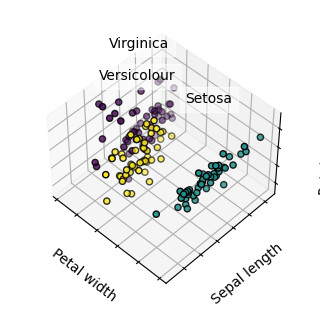

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(5)


iris = datasets.load_iris()
X = iris.data
y = iris.target
pca = LDA(n_components=3)
pca.fit(X, y)
X = pca.transform(X)

fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])
for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:    
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, 
        edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
# ax.set_title("Ground Truth")
ax.dist = 12

plt.show()

### Exercise 2 Recognize handwritten numbers with LDA (50 points ). 

Your task in this section is to recognize handwritten numbers, and you can use the linear discriminant analysis model from the Scikit-Learn library to fit, evaluate, and predict them.

<font color='red' size=4>Note that your accuracy in this section will directly determine your score.</font>

### Loading the MNIST Dataset


In [5]:
import struct
import numpy as np

def read_idx3(filename):
    with open(filename, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        data = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        
    return data

def read_idx1(filename):
    with open(filename, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8).reshape(num_labels)
        
    return labels



In [6]:
########### Write Your Code Here ###########

train_images = read_idx3('mnist/train-images.idx3-ubyte')
train_labels = read_idx1('mnist/train-labels.idx1-ubyte')
test_imagse = read_idx3('mnist/t10k-images.idx3-ubyte')
test_labels = read_idx1('mnist/t10k-labels.idx1-ubyte')

############################################

###  Visualization of MINIST

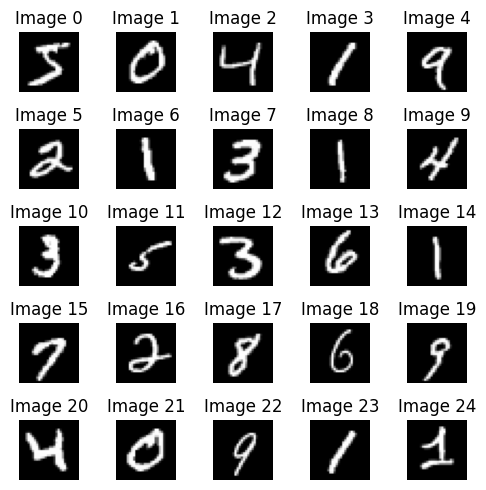

In [7]:
# Visualize MINIST
########### Write Your Code Here ###########

import matplotlib.pyplot as plt

num_rows, num_cols = 5, 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for i in range(num_rows):
    for j in range(num_cols):
        image_index = i * num_cols + j
        if image_index < len(train_images):
            axes[i, j].imshow(train_images[image_index], cmap='gray')
            axes[i, j].set_title(f'Image {image_index}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

############################################

### Fit  Model

In [8]:
########### Write Your Code Here ###########

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(5)

X = train_images.reshape(train_images.shape[0], -1)
y = train_labels
pca = LDA()
pca.fit(X, y)

############################################

## Evaluate model

In [9]:
########### Write Your Code Here ###########

from sklearn.metrics import accuracy_score

image_transform, pre_labels = pca.fit_transform(test_imagse.reshape(test_imagse.shape[0], -1))
y_test = test_labels

accuracy_score(y_test,pre_labels)
############################################


0.7045

### Exercise 3: Qustions
- Q1:What are the advantages and disadvantages of LDA?


- Q2 LDA can be used for dimensionality reduction, so can PCA. Please tell the difference between them?

Q1: Advantages and Disadvantages of LDA (Linear Discriminant Analysis):

Advantages:
1. LDA is a supervised dimensionality reduction technique. It takes into account class labels or categories, making it useful for classification problems.

2. LDA aims to maximize the separation between different classes in the data. This helps in reducing the overlap between classes and improving classification performance.

3. LDA can transform the original features into a lower-dimensional space while preserving class-related information. This can lead to more efficient and effective classification models.

4. By reducing the dimensionality of the data, LDA can help in reducing the risk of overfitting in machine learning models.

Disadvantages:

1. LDA assumes that the data follows a normal distribution, which might not always be the case in real-world datasets.

2. LDA can be sensitive to outliers in the data, which may affect its performance.

3. LDA is inherently a supervised technique and may not be the best choice for unsupervised dimensionality reduction or feature extraction.

4. Like other dimensionality reduction techniques, LDA involves a loss of information when reducing the dimensionality of the data.

---

Q2: Difference between LDA and PCA for Dimensionality Reduction:

1. **Objective:**

   - LDA (Linear Discriminant Analysis) is a supervised technique that aims to maximize the separation between different classes or categories in the data. It is primarily used for feature extraction in the context of classification.
   - PCA (Principal Component Analysis) is an unsupervised technique that aims to find orthogonal axes (principal components) that capture the maximum variance in the data. It is primarily used for dimensionality reduction and data compression.

2. **Use of Class Labels:**

   - LDA uses class labels or categories in its computation to maximize class separability. It considers the structure of the data in relation to the target variable.
   - PCA is unsupervised and does not consider class labels. It operates solely based on the variance of the data.

3. **Dimensionality Reduction:**

   - LDA reduces dimensionality while preserving class-related information. It transforms the data into a lower-dimensional space where classes are well-separated.
   - PCA reduces dimensionality by finding orthogonal components that explain the variance in the data but does not consider class separability. 


